# Prediction of the utilization using Neural Networks

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
from keras import Sequential
from keras.layers import Dense, Dropout

%matplotlib inline

### Cross validation and normalizing

We will perform the predictions for site 1 and site 2 separately, because they have different characteristics. 
The random state parameter means that the cross validation is reproducible and can be performed in the same way for the prediction using polynomial regression.

In [2]:
# read in the preprocessed data
Input_hourly = pd.read_csv('input_hourly.csv', parse_dates=['date'])

# split into input and output
X_site1 = Input_hourly.drop(["time_id", "date", "site1_utilization_percentage", "site2_utilization_percentage"], axis=1)
y_site1 = Input_hourly["site1_utilization_percentage"]

X_site2 = Input_hourly.drop(["time_id", "date", "site1_utilization_percentage", "site2_utilization_percentage"], axis=1)
y_site2 = Input_hourly["site2_utilization_percentage"]

# cross-validation
X_train_site1, X_test_site1, y_train_site1, y_test_site1 = train_test_split(X_site1, y_site1, test_size=0.3, random_state=42)

X_train_site2, X_test_site2, y_train_site2, y_test_site2 = train_test_split(X_site2, y_site2, test_size=0.3, random_state=42)

# normalize the data, save the original values and delete columns
X_train_site1_original = X_train_site1.copy()
X_test_site1_original = X_test_site1.copy()

X_train_site1 = X_train_site1.drop(["hour", "month", "dayOfTheWeek"], axis=1)
X_test_site1 = X_test_site1.drop(["hour", "month", "dayOfTheWeek"], axis=1)

scaler_site1 = StandardScaler()
scaler_site1.fit(X_train_site1)

X_train_site1 = scaler_site1.transform(X_train_site1)
X_test_site1 = scaler_site1.transform(X_test_site1)

X_train_site2_original = X_train_site2.copy()
X_test_site2_original = X_test_site2.copy()

X_train_site2 = X_train_site2.drop(["hour", "month", "dayOfTheWeek"], axis=1)
X_test_site2 = X_test_site2.drop(["hour", "month", "dayOfTheWeek"], axis=1)

scaler_site2 = StandardScaler()
scaler_site2.fit(X_train_site2)

X_train_site2 = scaler_site2.transform(X_train_site2)
X_test_site2 = scaler_site2.transform(X_test_site2)

## Utilization prediction of site 1

### Model definition (site 1)

In [3]:
model_site1 = Sequential(
    [Dense(36, activation="relu", input_shape=[X_train_site1.shape[1]]),
    Dense(36, activation="relu"),
     Dense(1)])
model_site1.compile(loss='mse',
             optimizer="adam",
             metrics=["mae", "mse"])
model_site1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 36)                1656      
                                                                 
 dense_1 (Dense)             (None, 36)                1332      
                                                                 
 dense_2 (Dense)             (None, 1)                 37        
                                                                 
Total params: 3,025
Trainable params: 3,025
Non-trainable params: 0
_________________________________________________________________


### Training the model (site 1)

Epoch 1/20
215/215 [==============================] - 2s 5ms/step - loss: 512.0435 - mae: 13.3940 - mse: 512.0435 - val_loss: 240.7045 - val_mae: 10.9425 - val_mse: 240.7045
Epoch 2/20
215/215 [==============================] - 1s 3ms/step - loss: 149.8233 - mae: 8.0636 - mse: 149.8233 - val_loss: 138.2087 - val_mae: 7.4631 - val_mse: 138.2087
Epoch 3/20
215/215 [==============================] - 1s 3ms/step - loss: 113.2622 - mae: 6.4028 - mse: 113.2622 - val_loss: 123.6857 - val_mae: 6.5843 - val_mse: 123.6857
Epoch 4/20
215/215 [==============================] - 1s 4ms/step - loss: 102.9625 - mae: 5.6200 - mse: 102.9625 - val_loss: 117.1609 - val_mae: 5.9769 - val_mse: 117.1609
Epoch 5/20
215/215 [==============================] - 1s 3ms/step - loss: 99.5301 - mae: 5.1741 - mse: 99.5301 - val_loss: 116.5400 - val_mae: 5.7652 - val_mse: 116.5400
Epoch 6/20
215/215 [==============================] - 1s 3ms/step - loss: 97.2533 - mae: 4.9685 - mse: 97.2533 - val_loss: 110.9117 - val_ma

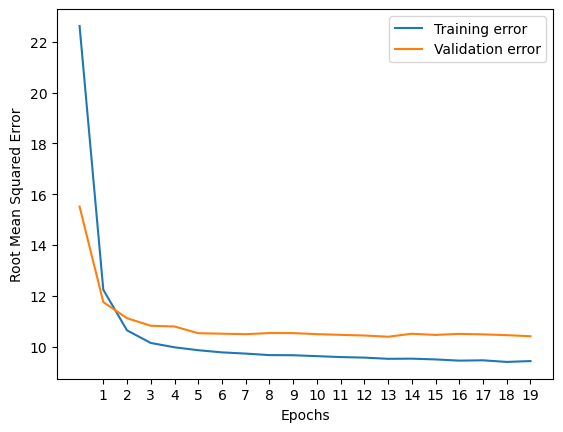

In [4]:
epochs_site1 = 20

# train the model
history_site1 = model_site1.fit(X_train_site1, y_train_site1.values,
                   epochs=epochs_site1, validation_split=0.2)
history_site1 = pd.DataFrame(history_site1.history)

# compute rmse
root_metrics_site1 = history_site1[["mse", "val_mse"]].apply(np.sqrt)
root_metrics_site1.rename({"mse":"rmse", "val_mse":"val_rmse"}, axis=1, inplace=True)

# plot rmse of the training and validation set per epoch
plt.Figure(figsize=(14,6), dpi=100)
plt.plot(root_metrics_site1["rmse"], label = 'Training error')
plt.plot(root_metrics_site1["val_rmse"], label = 'Validation error')

plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error")

plt.xticks(range(1,20))
plt.legend()

plt.show()

### Prediction (site 1)

In [5]:
# prediction using the trained model
y_pred_site1 = model_site1.predict(X_test_site1)

115/115 [==============================] - 0s 2ms/step


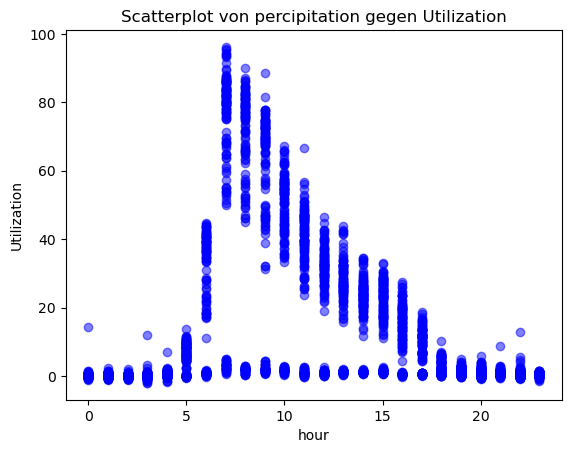

,month,hour,dayOfTheWeek,temperature,precipitation,day_0,day_1,day_2,day_3,day_4,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
9849,11,14,4,20.0,0.0,False,False,False,False,True,...,True,False,False,False,False,False,False,False,False,False
11668,2,9,3,12.0,0.0,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
9850,11,15,4,19.0,0.0,False,False,False,False,True,...,False,True,False,False,False,False,False,False,False,False
10587,12,8,0,11.0,0.0,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7248,8,6,1,19.0,0.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,11,7,1,12.0,0.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2264,1,13,3,18.0,0.0,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
5228,5,2,1,16.0,0.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10856,1,13,4,23.0,0.0,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [6]:
hour = X_test_site1_original["hour"]
utilization = y_pred_site1

# Scatterplot erstellen
plt.scatter(hour, utilization, color='blue', alpha=0.5)
plt.title('Scatterplot von percipitation gegen Utilization')
plt.xlabel('hour')
plt.ylabel('Utilization')
plt.show()
X_test_site1_original

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


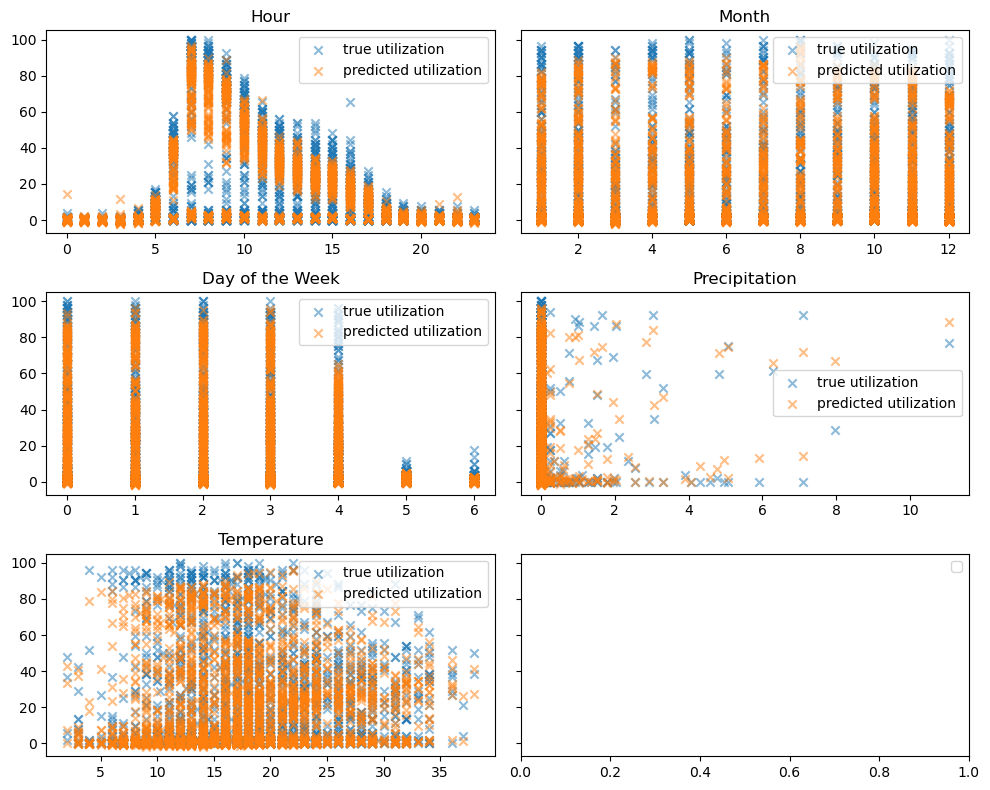

In [24]:
# subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 8), sharey=True)

# "hour"
axs[0, 0].scatter(X_test_site1_original['hour'], y_test_site1, label='true utilization', marker='x', alpha=0.5)
axs[0, 0].scatter(X_test_site1_original['hour'], y_pred_site1, label='predicted utilization', marker='x', alpha=0.5)
axs[0, 0].set_title('Hour')

# "month"
axs[0, 1].scatter(X_test_site1_original['month'], y_test_site1, label='true utilization', marker='x', alpha=0.5)
axs[0, 1].scatter(X_test_site1_original['month'], y_pred_site1, label='predicted utilization', marker='x', alpha=0.5)
axs[0, 1].set_title('Month')

# "dayOfTheWeek"
axs[1, 0].scatter(X_test_site1_original['dayOfTheWeek'], y_test_site1, label='true utilization', marker='x', alpha=0.5)
axs[1, 0].scatter(X_test_site1_original['dayOfTheWeek'], y_pred_site1, label='predicted utilization', marker='x', alpha=0.5)
axs[1, 0].set_title('Day of the Week')

# "precipitation"
axs[1, 1].scatter(X_test_site1_original['precipitation'], y_test_site1, label='true utilization', marker='x', alpha=0.5)
axs[1, 1].scatter(X_test_site1_original['precipitation'], y_pred_site1, label='predicted utilization', marker='x', alpha=0.5)
axs[1, 1].set_title('Precipitation')

# "temperature"
axs[2, 0].scatter(X_test_site1_original['temperature'], y_test_site1, label='true utilization', marker='x', alpha=0.5)
axs[2, 0].scatter(X_test_site1_original['temperature'], y_pred_site1, label='predicted utilization', marker='x', alpha=0.5)
axs[2, 0].set_title('Temperature')

# legend
for ax in axs.flat:
    ax.legend()

# layout
plt.tight_layout()
plt.show()

### Evaluation (site 1)

In [7]:
print("RMSE: ", np.sqrt(mean_squared_error(y_test_site1, y_pred_site1)))
print("MAE: ", mean_absolute_error(y_test_site1, y_pred_site1))
print("MAPE: ", mean_absolute_percentage_error(y_test_site1, y_pred_site1))

RMSE:  9.960766675788012
MAE:  4.824315348588879
MAPE:  3229687803840115.5


## Utilization prediction of site 2

### Model definition (site 2)

In [8]:
model_site2 = Sequential(
    [Dense(36, activation="relu", input_shape=[X_train_site2.shape[1]]),
    Dense(36, activation="relu"),
     Dense(1)])
model_site2.compile(loss='mse',
             optimizer="adam",
             metrics=["mae", "mse"])
model_site2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 36)                1656      
                                                                 
 dense_4 (Dense)             (None, 36)                1332      
                                                                 
 dense_5 (Dense)             (None, 1)                 37        
                                                                 
Total params: 3,025
Trainable params: 3,025
Non-trainable params: 0
_________________________________________________________________


### Training the model (site 2)

Epoch 1/20
215/215 [==============================] - 1s 4ms/step - loss: 82.0288 - mae: 5.4400 - mse: 82.0288 - val_loss: 39.5532 - val_mae: 4.1636 - val_mse: 39.5532
Epoch 2/20
215/215 [==============================] - 1s 3ms/step - loss: 37.8994 - mae: 3.8964 - mse: 37.8994 - val_loss: 31.2991 - val_mae: 3.5746 - val_mse: 31.2991
Epoch 3/20
215/215 [==============================] - 1s 3ms/step - loss: 33.7045 - mae: 3.5720 - mse: 33.7045 - val_loss: 29.5179 - val_mae: 3.3935 - val_mse: 29.5179
Epoch 4/20
215/215 [==============================] - 1s 3ms/step - loss: 32.5716 - mae: 3.4666 - mse: 32.5716 - val_loss: 28.9995 - val_mae: 3.3660 - val_mse: 28.9995
Epoch 5/20
215/215 [==============================] - 1s 3ms/step - loss: 31.8529 - mae: 3.4187 - mse: 31.8529 - val_loss: 29.0778 - val_mae: 3.3557 - val_mse: 29.0778
Epoch 6/20
215/215 [==============================] - 1s 3ms/step - loss: 31.4930 - mae: 3.4028 - mse: 31.4930 - val_loss: 28.4633 - val_mae: 3.3396 - val_mse: 

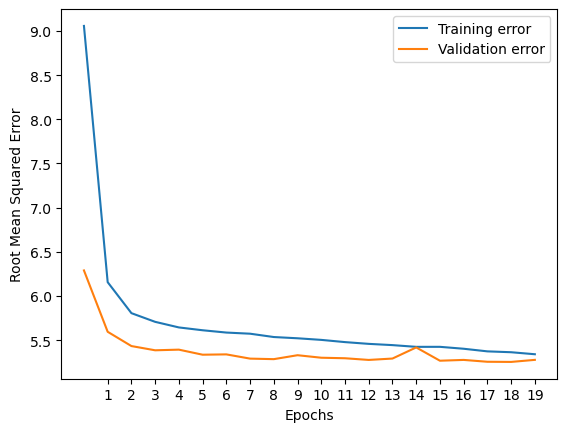

In [9]:
epochs_site2 = 20

# train the model
history_site2 = model_site2.fit(X_train_site2, y_train_site2.values,
                   epochs=epochs_site2, validation_split=0.2)
history_site2 = pd.DataFrame(history_site2.history)

# compute rmse
root_metrics_site2 = history_site2[["mse", "val_mse"]].apply(np.sqrt)
root_metrics_site2.rename({"mse":"rmse", "val_mse":"val_rmse"}, axis=1, inplace=True)

# plot rmse of the training and validation set per epoch
plt.Figure(figsize=(14,6), dpi=100)
plt.plot(root_metrics_site2["rmse"], label = 'Training error')
plt.plot(root_metrics_site2["val_rmse"], label = 'Validation error')

plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error")

plt.xticks(range(1,20))
plt.legend()

plt.show()

### Prediction (site 2)

In [10]:
# prediction using the trained model
y_pred_site2 = model_site2.predict(X_test_site2)

115/115 [==============================] - 0s 2ms/step


### Evaluation (site 2)

In [11]:
print("RMSE: ", np.sqrt(mean_squared_error(y_test_site2, y_pred_site2)))
print("MAE: ", mean_absolute_error(y_test_site2, y_pred_site2))
print("MAPE: ", mean_absolute_percentage_error(y_test_site2, y_pred_site2))

RMSE:  5.442477138728739
MAE:  3.3725116018446384
MAPE:  3020622986415799.0
